<a href="https://colab.research.google.com/github/kevalshah90/CV/blob/main/MVTech_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solve anomaly detection problem using a subset of the industrial [MVTec dataset](https://www.mvtec.com/company/research/datasets/mvtec-ad).
This subset contains photos of the bottle, where all train samples are good (non-anomalies), and test set has some anomalous defects.

We will evaluate the result of modeling using ROC AUC metric. Our goal is to reach the 0.9 bar.

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

np.random.seed(42)

Let's have a look at the data!

In [ ]:
!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz && tar -xf bottle.tar.xz && rm -rf bottle.tar.xz

--2024-06-19 15:12:28--  https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz
Resolving www.mydrive.ch (www.mydrive.ch)... 91.214.169.64
Connecting to www.mydrive.ch (www.mydrive.ch)|91.214.169.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155880244 (149M) [application/x-xz]
Saving to: ‘bottle.tar.xz’

bottle.tar.xz       100%[===================>] 148.66M  30.7MB/s    in 5.5s    

2024-06-19 15:12:35 (26.8 MB/s) - ‘bottle.tar.xz’ saved [155880244/155880244]



In [ ]:
# we only work with a single class of MVTec dataset for simplicity
dataset_path = './bottle/'

files = glob(dataset_path + '**/*.png', recursive=True)

# MVTec has only non-defective samples in train, defects are present in test only
# scikit-learn calls this  novelty detection problem https://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection

train_files = [x for x in files if 'train' in x]
train_labels = [1 if 'good' in x else 0 for x in train_files]
test_files = [x for x in files if 'test' in x]
test_labels = [1 if 'good' in x else 0 for x in test_files]

train_images = np.array([cv2.imread(x) for x in tqdm(train_files)])
test_images = np.array([cv2.imread(x) for x in tqdm(test_files)])

# cut the piece of test data to use as validation
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, shuffle=True, train_size=0.3, random_state=42)

100%|██████████| 83/83 [00:02<00:00, 31.89it/s]


Labels = {
           `0`: bad,
           `1`: good
         }

Contaminated Images

In [ ]:
f"% of good train labels: {train_labels.count(1)/len(train_labels)*100}%"

'% of good train labels: 100.0%'

In [ ]:
bad = [x for x in test_files if 'good' not in x]
f"% of bad test labels: {round(test_labels.count(0)/len(test_labels)*100,2)}%"

'% of bad test labels: 72.88%'

In [ ]:
f"% of bad validation labels: {round(val_labels.count(0)/len(val_labels)*100,2)}%"

'% of bad validation labels: 83.33%'

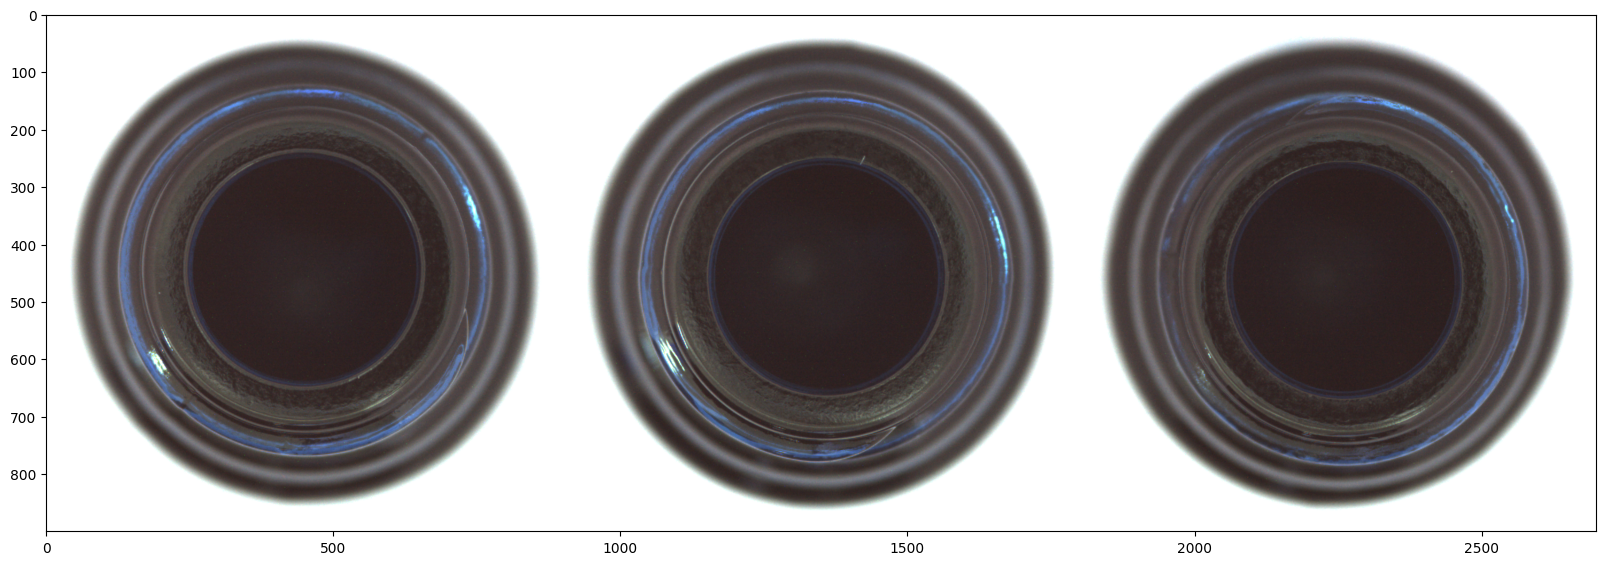

In [ ]:
# plotting some train (good) images

plt.imshow(np.hstack((train_images[0], train_images[1], train_images[2])))

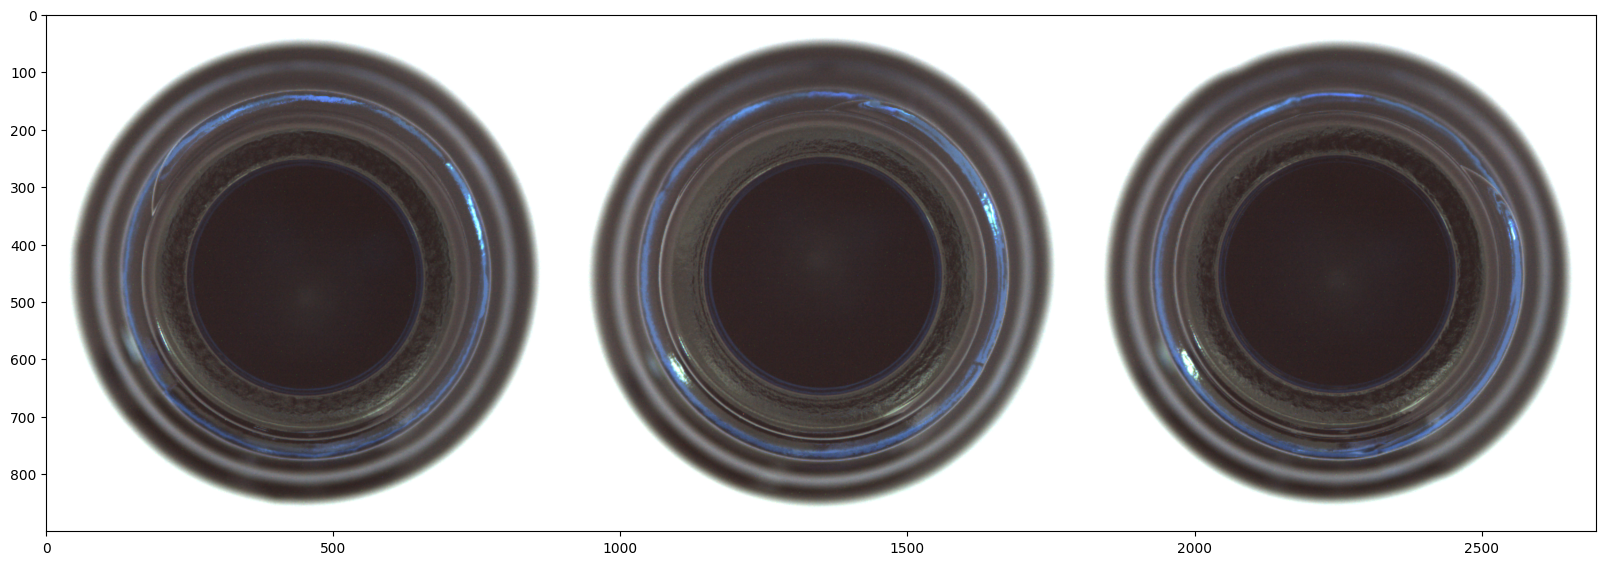

In [ ]:
# plotting some val (good) images

good_val = [img for img, label in zip(val_images, val_labels) if label == 1]
plt.imshow(np.hstack((good_val[0], good_val[1], good_val[2])))

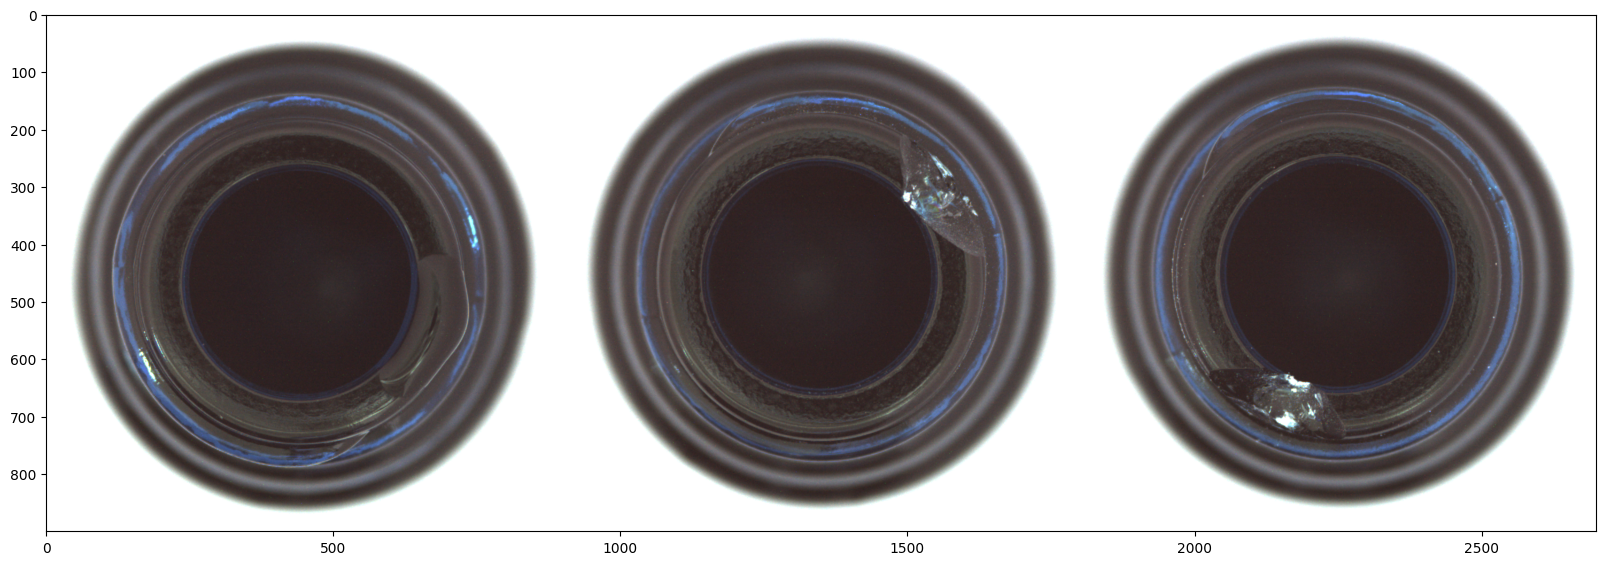

In [ ]:
# plotting some val (bad) images

bad_val = [img for img, label in zip(val_images, val_labels) if label == 0]
plt.imshow(np.hstack((bad_val[0], bad_val[1], bad_val[2])))

In [ ]:
train_images.shape

(209, 900, 900, 3)

The shape indicates that there are `209` image samples, each with `900x900` dimensions and 3 color channels (RGB) format.

As a baseline, let's build a very simple model based on pixel histogram features.

In [ ]:
def histogram_features(img, n_bins=64):
    hist, _ = np.histogram(img, bins=n_bins)
    return hist

train_features = np.array([histogram_features(x) for x in tqdm(train_images)])
val_features = np.array([histogram_features(x) for x in tqdm(val_images)])
test_features = np.array([histogram_features(x) for x in tqdm(test_images)])

100%|██████████| 59/59 [00:02<00:00, 25.92it/s]


In [ ]:
train_features.shape

(209, 64)

In [ ]:
val_features.shape

(24, 64)

In [ ]:
test_features.shape

(59, 64)

Time to fit some models!

In [ ]:
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

models = (
    (IsolationForest, {'n_estimators': 10, 'random_state': 42}),
    (IsolationForest, {'n_estimators': 50, 'random_state': 42}),
    (IsolationForest, {'n_estimators': 100, 'random_state': 42}),
    (EllipticEnvelope, {'random_state': 42, 'support_fraction': .75}),
    (LocalOutlierFactor, {'novelty': True, 'n_neighbors': 5}),
    (LocalOutlierFactor, {'novelty': True, 'n_neighbors': 20}),
    (OneClassSVM, {'kernel': 'linear', 'nu': 0.1, 'gamma': 'auto'})
    #(OneClassSVM, {'kernel': 'poly', 'degree': 6, 'nu': 0.1, 'gamma': 'auto'}),
    #(OneClassSVM, {'kernel': 'rbf', 'nu': 0.1, 'gamma': 'auto'})
    )

result = []
for cls, params in models:
    model = cls(**params)
    model.fit(train_features)
    val_scores = model.decision_function(val_features)
    score = roc_auc_score(val_labels, val_scores)
    print(f'model {model}, val score {score:.3f}')

    result.append(((cls, params), score))

(best_model, best_params), best_score = sorted(result, key = lambda x: x[1])[-1]

model = best_model(**best_params).fit(train_features)
test_scores = model.decision_function(test_features)
print()
print(f'Final score is {roc_auc_score(test_labels, test_scores):.3f} using {best_model} {best_params}')

model IsolationForest(n_estimators=10, random_state=42), val score 0.611
model IsolationForest(n_estimators=50, random_state=42), val score 0.509
model IsolationForest(random_state=42), val score 0.583
model EllipticEnvelope(random_state=42, support_fraction=0.75), val score 0.500
model LocalOutlierFactor(n_neighbors=5, novelty=True), val score 0.657
model LocalOutlierFactor(novelty=True), val score 0.676
model OneClassSVM(gamma='auto', kernel='linear', nu=0.1), val score 0.880

Final score is 0.795 using <class 'sklearn.svm._classes.OneClassSVM'> {'kernel': 'linear', 'nu': 0.1, 'gamma': 'auto'}


Since baseline results are not very strong, let's try a more modern deep learning-based approach!

**Convolutional Neural Network**

CNNs are a type of deep learning model particularly effective for processing grid-like data, such as images. They're designed to automatically learn spatial hierarchies of features from input data. Here are the key components:

1.   Convolutional Layers: Apply learnable filters to the input, creating feature maps.

2.   Pooling Layers: Reduce spatial dimensions of feature maps, improving efficiency.

3.   Activation Functions: Introduce non-linearity, typically using ReLU.

4.   Fully Connected Layers: Use learned features to make final classification decisions.

**When using a ConvNet as a fixed feature extractor:**

`Layers Up to a Certain Point`: Instead of re-training the entire ConvNet from scratch for a new task (which can be computationally expensive and data-intensive), we keep the pre-trained ConvNet's weights fixed and only use it to extract features up to a certain layer.

`Feature Extraction`: The earlier layers of a ConvNet capture low-level features like edges, textures, and basic shapes. As we move deeper into the network, the layers capture increasingly complex and abstract features relevant to the specific dataset on which the ConvNet was originally trained.

`New Classifier`: After extracting features using the fixed ConvNet, these features are fed into a new classifier (typically a fully connected layer or a few additional layers) that is trained specifically for the new task. This new classifier is trained using the extracted features and labeled data from the new task.

DINO
CLIP

Use backbone for your data.

Train MLP.

Seperate Anomalous features from normal.

- DiNO v2 - PCA - Plot RGB
-

**Feature Extraction:**

The earlier layers of CNNs, like ResNet50, are responsible for detecting low-level features (e.g., edges, textures) in the input images.
As we go deeper, the layers detect more complex, high-level features (e.g., shapes, objects).
By removing the FC layer, we leverage the feature extraction capabilities of the CNN without using the final classification layer, which is specific to the pre-training task (e.g., classifying ImageNet categories).
Generalization:

The high-level features learned by the model are general and can be useful for various tasks, including anomaly detection.
These features can capture the essence of the input data, making it easier to detect deviations (anomalies).


In [ ]:
# In particular, we'll use features from one of the common CNN architectures
# Inspired by https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor

import torch
from torchvision.models import mobilenet_v3_small, resnet50, resnet18

# we use a relatively small network because the dataset is small too
#encoder = mobilenet_v3_small()
# remove last layer of the encoder
#encoder.classifier = torch.nn.Identity()

#encoder = resnet50(pretrained=True)
#encoder = torch.nn.Sequential(*list(encoder.children())[:-1])

encoder = resnet18(pretrained=True)
encoder = torch.nn.Sequential(*list(encoder.children())[:-1])

#encoder

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


Pass the image tensor through the encoder to extract deep features.

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} for inference')
encoder.to(device)

def deep_features(img):
    smaller_img = cv2.resize(img, (400, 400))
    # Normalize the image (adjust normalization values if needed)
    smaller_img = smaller_img.astype(np.float32) / 255.0
    """
    The np.transpose function is used to rearrange the axes to (channels, height, width) from (height, width, channels)
    as that is the expected format of pytorch model.
    """
    tensor = torch.from_numpy(np.transpose(smaller_img, (2, 0, 1)).astype('float32')).to(device)
    with torch.no_grad():
        return encoder(tensor.unsqueeze(0)).squeeze().cpu().numpy()

deep_train_features = np.array([deep_features(x) for x in tqdm(train_images)])
deep_val_features = np.array([deep_features(x) for x in tqdm(val_images)])
deep_test_features = np.array([deep_features(x) for x in tqdm(test_images)])

Using cpu for inference


100%|██████████| 59/59 [00:17<00:00,  3.36it/s]


**Training the Anomaly Detection Model:**

Use these feature vectors to train an anomaly detection algorithm (e.g., Isolation Forest, One-Class SVM).
During training, the model learns the normal patterns in the feature space.

In [ ]:
# Define your models and their hyperparameter grids
param_grid = {
    'IsolationForest': {'n_estimators': [10, 50, 100], 'random_state': [42], 'contamination': [0.05, 0.1, 0.2, 0.5, 0.6, 0.75, 0.8, 0.9]},
    'EllipticEnvelope': {'support_fraction': [0.5, 0.75, 0.8, 0.9], 'random_state': [42]},
    'LocalOutlierFactor': {'novelty': [True], 'n_neighbors': [5, 20]},
    'OneClassSVM': {'kernel': ['linear','rbf','poly'], 'degree': [2, 4, 6, 8], 'nu': [0.05, 0.1, 0.2, 0.5, 0.6], 'gamma': ['auto']},
}

models = {
    'IsolationForest': IsolationForest,
    'EllipticEnvelope': EllipticEnvelope,
    'LocalOutlierFactor': LocalOutlierFactor,
    'OneClassSVM': OneClassSVM,
}

In [ ]:
# deep_models = models = [
#     #(IsolationForest(), {'n_estimators': [10, 50, 100, 400], 'random_state': [42], 'contamination': [0.05, 0.1, 0.2, 0.5, 0.6, 0.75, 0.8, 0.9]}),
#     #(EllipticEnvelope(), {'support_fraction': [0.5, 0.75, 0.9]}),
#     #(LocalOutlierFactor(), {'novelty': [True], 'n_neighbors': [5, 20]}),
#     (OneClassSVM(), {'kernel': ['linear','rbf', 'poly'], 'degree': [2, 4, 6, 8], 'nu': [0.05, 0.1, 0.2, 0.5, 0.6], 'gamma':['auto']})
# ]

In [ ]:
result = []

for name, model_cls in models.items():
    #model = cls(**params)
    #model.fit(deep_train_features)

    print('model', model_cls)

    grid_search = GridSearchCV(estimator=model_cls(), param_grid=param_grid[name], cv=5, scoring='roc_auc', n_jobs=-1, verbose=5)
    grid_search.fit(deep_train_features, train_labels)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    #model = best_model(**best_params).fit(deep_train_features)

    val_scores = best_model.decision_function(deep_val_features)

    score = roc_auc_score(val_labels, val_scores)

    print(f'model {best_model}, val score {score:.3f}')

    result.append(((model_cls, best_params), score))


model <class 'sklearn.ensemble._iforest.IsolationForest'>
Fitting 5 folds for each of 24 candidates, totalling 120 fits
model IsolationForest(contamination=0.05, n_estimators=10, random_state=42), val score 0.861
model <class 'sklearn.covariance._elliptic_envelope.EllipticEnvelope'>
Fitting 5 folds for each of 4 candidates, totalling 20 fits
model EllipticEnvelope(random_state=42, support_fraction=0.5), val score 1.000
model <class 'sklearn.neighbors._lof.LocalOutlierFactor'>
Fitting 5 folds for each of 2 candidates, totalling 10 fits
model LocalOutlierFactor(n_neighbors=5, novelty=True), val score 1.000
model <class 'sklearn.svm._classes.OneClassSVM'>
Fitting 5 folds for each of 60 candidates, totalling 300 fits
model OneClassSVM(degree=2, gamma='auto', kernel='linear', nu=0.05), val score 0.935


In [ ]:
result

[((sklearn.ensemble._iforest.IsolationForest,
   {'contamination': 0.05, 'n_estimators': 10, 'random_state': 42}),
  0.8611111111111112),
 ((sklearn.covariance._elliptic_envelope.EllipticEnvelope,
   {'random_state': 42, 'support_fraction': 0.5}),
  1.0),
 ((sklearn.neighbors._lof.LocalOutlierFactor,
   {'n_neighbors': 5, 'novelty': True}),
  1.0),
 ((sklearn.svm._classes.OneClassSVM,
   {'degree': 2, 'gamma': 'auto', 'kernel': 'linear', 'nu': 0.05}),
  0.9351851851851852)]

In [ ]:
(best_model, best_params), best_score = sorted(result, key=lambda x: x[1])[-1]
(best_model, best_params), best_score

((sklearn.neighbors._lof.LocalOutlierFactor,
  {'n_neighbors': 5, 'novelty': True}),
 1.0)

In [ ]:
best_model = best_model(**best_params)
best_model.fit(deep_train_features)  # Fit directly on the features

LocalOutlierFactor(n_neighbors=5, novelty=True)

In [ ]:
#model = best_model(**best_params).fit(deep_train_features)
test_scores = best_model.decision_function(deep_test_features)
print()
print(f'Final score is {roc_auc_score(test_labels, test_scores):.3f} using {best_model} {best_params}')


Final score is 0.967 using LocalOutlierFactor(n_neighbors=5, novelty=True) {'n_neighbors': 5, 'novelty': True}


**Notes on work completed**

*   Added `train_labels`
*   Implemented `grid_searchCV` to try different combinations of hyperparameters.
*   Updated image size, larger images retain more spatial information.
*   Used a different model backbone `ResNet18` instead of `MobileNetV3`
  - At a high level, the `MobileNetV3` (2.5M parameters) is a lightweight, shallower model optimized for inference speed vs accuracy.
  - `ResNet18` (11.6M parameters) is deeper network with more convolutional layers and key architectural implementation that improve training and accuracy.

Results:

1. `Final score` is `0.967` using `LocalOutlierFactor(n_neighbors=5, novelty=True) {'n_neighbors': 5, 'novelty': True}`


References:

- https://pytorch.org/blog/torchvision-mobilenet-v3-implementation/

- https://pytorch.org/vision/master/models/generated/torchvision.models.resnet18.html
